In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


# To do:
1) Split into test and training samples - Done!
2) Check classes are balanced - They are not, BALANCE THEM 
3) Use heat map to reduce correlations - Done!
4) Use boosted decision tree - Done!
5) Function to optimize hyperparameters - Done!
6) Try LogisticRegression if variables meet criteria
7) Try neural network
8) Create pairplots to check variable relationships - Done!
9) Use Principal Components Analysis to reduce correlations


In [2]:
df = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
df.fillna(0,inplace=True)
X = df.drop(columns='rainfall')
y = df['rainfall']

X_final = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
X_final.fillna(0,inplace=True)
X_final_id = X_final[['id']]

In [3]:
print(df.head())

   id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  
0   88.0       1.1           60.0       17.2         1  
1   91.0       0.0           50.0       21.9         1  
2   47.0       8.3           70.0       18.1         1  
3   95.0       0.0           60.0       35.6         1  
4   45.0       3.6           40.0       24.8         0  


In [4]:
print(df.describe())

                id          day     pressure      maxtemp  temparature  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean   1094.500000   179.948402  1013.602146    26.365799    23.953059   
std     632.342866   105.203592     5.655366     5.654330     5.222410   
min       0.000000     1.000000   999.000000    10.400000     7.400000   
25%     547.250000    89.000000  1008.600000    21.300000    19.300000   
50%    1094.500000   178.500000  1013.000000    27.800000    25.500000   
75%    1641.750000   270.000000  1017.775000    31.200000    28.400000   
max    2189.000000   365.000000  1034.600000    36.000000    31.500000   

           mintemp     dewpoint     humidity        cloud     sunshine  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean     22.170091    20.454566    82.036530    75.721918     3.744429   
std       5.059120     5.288406     7.800654    18.026498     3.626327   
min       4.000000    -0.300000    39

# Feature selection/modification

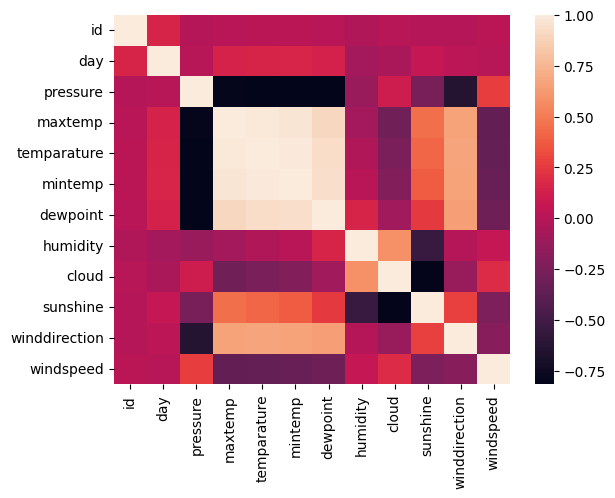

rainfall
1    1650
0     540
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

In [5]:
corr = X.corr()
sns.heatmap(corr)
plt.show()
plt.clf()

print(y.value_counts())

In [6]:
# check which feature pairs have |rho|>0.75
def check_corr(corr):
    cols = list(corr.columns)
    vals = corr.values
    for i in range(len(cols)):
        for j in range(i+1,len(cols)):
            if abs(vals[i,j])>0.7:
                print(cols[i],"and",cols[j],"have corr=",abs(vals[i,j]))
check_corr(corr)

pressure and maxtemp have corr= 0.8004990246459617
pressure and temparature have corr= 0.8165308522258306
pressure and mintemp have corr= 0.8144533378715528
pressure and dewpoint have corr= 0.8170079548796162
maxtemp and temparature have corr= 0.9829317560786646
maxtemp and mintemp have corr= 0.9655287301769214
maxtemp and dewpoint have corr= 0.9067025850131254
temparature and mintemp have corr= 0.9871499535596853
temparature and dewpoint have corr= 0.9336174104477594
mintemp and dewpoint have corr= 0.9413416333402178
cloud and sunshine have corr= 0.8051284328564674


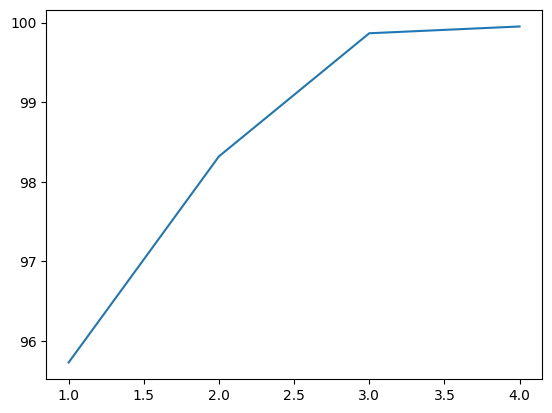

              PC1         PC2        PC3        PC4
0    -1098.787442  152.606424 -38.131628  -9.865562
1    -1097.759638  152.383098 -49.167653 -15.856158
2    -1096.741630  149.864662 -28.234834  31.746543
3    -1095.707688  149.926045 -39.283909 -21.379240
4    -1094.662956  149.286507 -57.931129  39.799119
...           ...         ...        ...        ...
2185  1094.891666 -148.612713 -72.851471 -15.621162
2186  1095.916874 -149.965897 -63.923392 -16.671495
2187  1096.950513 -150.559464 -73.699072  -3.582830
2188  1097.966764 -151.296993 -74.390344 -19.534576
2189  1098.989507 -153.997979 -44.129814 -17.901795

[2190 rows x 4 columns]
99.86481235526978


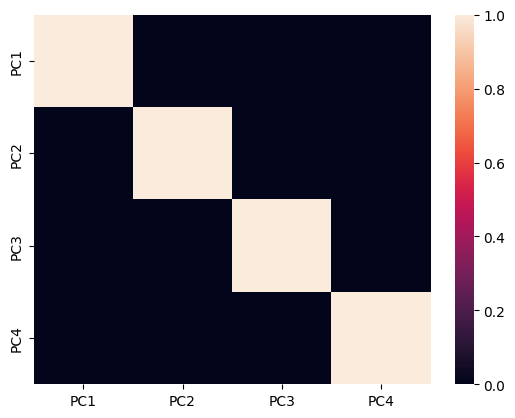

<Figure size 640x480 with 0 Axes>

In [7]:
# there is redundant info in temp, maxtemp, min temp, humidity, and dew point
# We don't care so much about interprability, we just want to predict if it rains
# can use Principal Components Analysis
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X = pd.DataFrame(pca.fit_transform(X))
X_final = pd.DataFrame(pca.transform(X_final))
updated_df = X.copy()
updated_df.columns = ["PC"+str(i+1) for i in range(len(updated_df.columns))]
X_final.columns = ["PC"+str(i+1) for i in range(len(updated_df.columns))]
X.columns = ["PC"+str(i+1) for i in range(len(updated_df.columns))]
comps = pca.components_
var_ratio = pca.explained_variance_ratio_*100
cum_sum_var = np.cumsum(var_ratio)
vals = [i+1 for i in range(len(var_ratio))]
plt.plot(vals,cum_sum_var)
plt.show()
plt.clf()

# need at most 3 principal components, describes 99.86% of variance
print(updated_df)
print(cum_sum_var[2])

new_corr = updated_df.corr()
sns.heatmap(new_corr)
plt.show()
plt.clf()

[1 0]
          rainfall
PC1       0.033649
PC2       0.007456
PC3      -0.011384
PC4      -0.648916
rainfall  1.000000


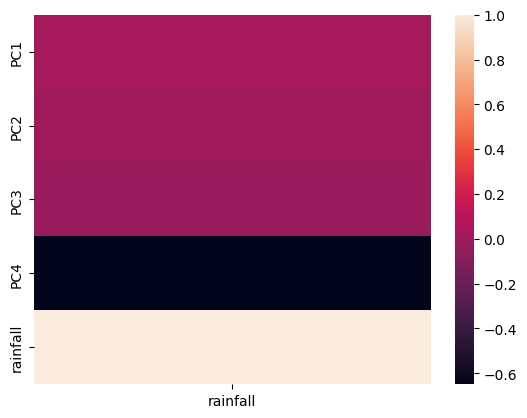

<Figure size 640x480 with 0 Axes>

In [8]:
# which features are most correlated with the outcome variable?
# note pearson correlation could be neglecting nonlinear effects
updated_df['rainfall'] = y
print(updated_df['rainfall'].unique())
corr_pred = updated_df.corr()
corr_pred = corr_pred[['rainfall']]
print(corr_pred)
sns.heatmap(corr_pred)
plt.show()
plt.clf()

In [9]:
# use pairplot to get overview of relationships between vars
#sns.pairplot(updated_df)
#plt.show()

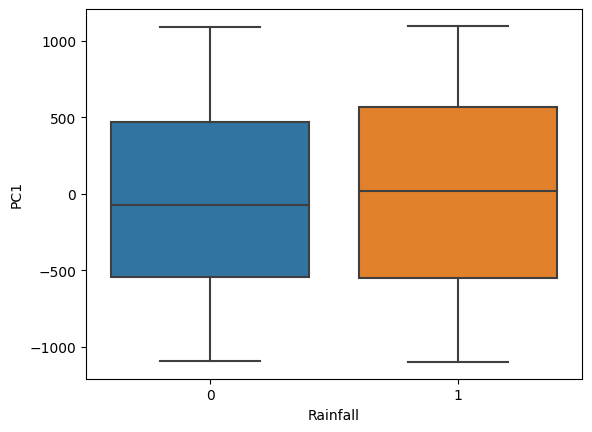

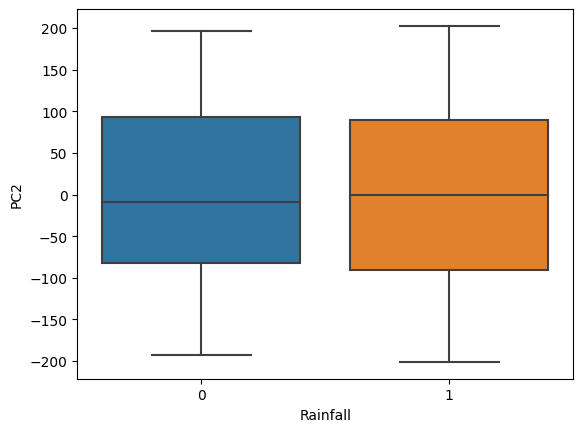

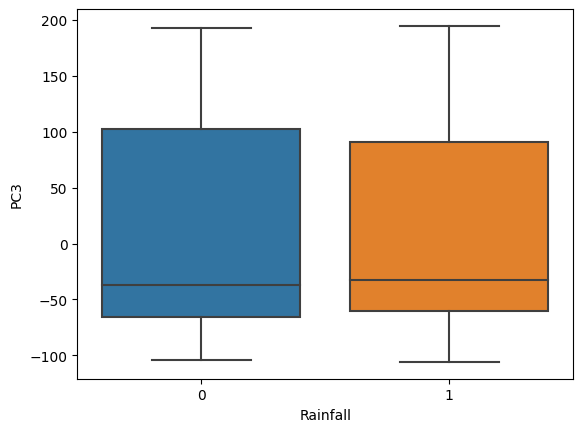

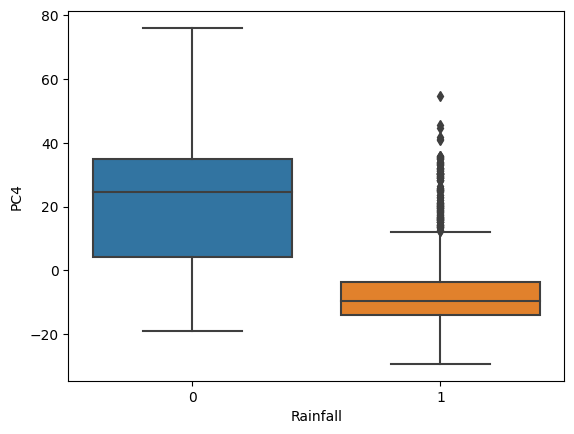

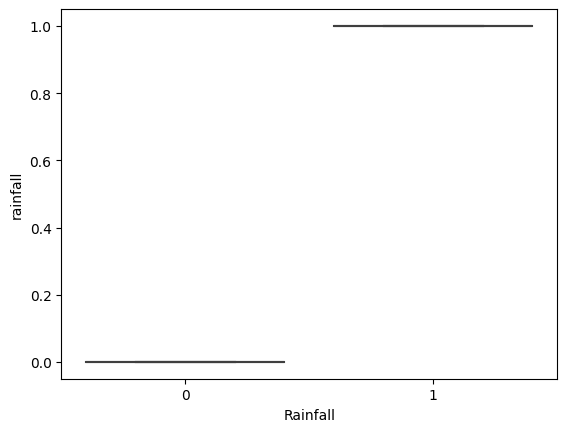

<Figure size 640x480 with 0 Axes>

In [10]:
params = list(updated_df.columns)
for param in params:
    sns.boxplot(x=updated_df['rainfall'],y=updated_df[param])
    plt.ylabel(param)
    plt.xlabel("Rainfall")
    plt.show()
    plt.clf()
    

# Split into test/train samples

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X = updated_df.drop(columns=['rainfall'])
y = updated_df['rainfall']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Model Selection
Could use KNeighborsClassifier, DecisionTreeClassifier, XGBClassifier, LogisticRegression, or Neural Network

In [12]:
# can do decision tree with no preprocessing
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
# need scaled features for knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [13]:
depths = [i for i in range(1,10)]
# optimize depth for regular decision tree
#tree_test_acc = optimize_hyperparam("",depths,X,y)

params = {"max_depth":depths}

clf = GridSearchCV(DecisionTreeClassifier(class_weight="balanced"),params,return_train_score=True,cv=5,scoring="f1")
clf.fit(X_train,y_train)
tree_train_score = clf.best_score_
tree_test_score = clf.score(X_test,y_test)
print(clf.best_params_)
tree_predictions = pd.DataFrame(clf.predict(X_final))

{'max_depth': 1}


In [14]:
depths = [i for i in range(1,20)]
params = {"max_depth":depths}
clf_xgb = GridSearchCV(xgb.XGBClassifier(),params,scoring='f1')
clf_xgb.fit(X_train,y_train)

xgb_train_score = clf_xgb.best_score_
xgb_test_score = clf_xgb.score(X_test,y_test)

xgb_predictions = clf_xgb.predict(X_final)

print(clf_xgb.best_params_)
#best_xgb.get_booster().dump_model("xgb_model.txt",with_stats=True)
#with open("xgb_model.txt","r") as f:
    #print(f.read())

{'max_depth': 1}


In [15]:
# next, try knearest neighbors
#Need to standardize data first
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_trans_train = scaler.fit_transform(X_train)
X_trans_test = scaler.transform(X_test)
X_trans_final = scaler.transform(X_final)

neighbors = [i for i in range(1,25)]

# now try with gridsearchcv
params = {"weights":["uniform","distance"],"n_neighbors":neighbors}
clf = GridSearchCV(KNeighborsClassifier(),params,cv=5,scoring="f1")

clf.fit(X_trans_train,y_train)
knn_train_score = clf.best_score_
knn_test_score = clf.score(X_trans_test,y_test)
knn_predictions = clf.predict(X_trans_final)

In [16]:
# finally, try LogisticRegression with various thresholds
from sklearn.linear_model import LogisticRegression
Cvals = np.logspace(-3,2)
params = {"penalty":["l1","l2"],"C":Cvals}

model = LogisticRegression(solver='liblinear',max_iter=1000)
clf = GridSearchCV(model,params,cv=5,scoring='f1')
clf.fit(X_train,y_train)
lr_train_score = clf.best_score_
lr_test_score = clf.score(X_test,y_test)

lr_predictions = clf.predict(X_final)


In [17]:
# make decision on which predictions to use
print("Train f1 score for tree was ",tree_train_score)
print("Train f1 score for knn was ",knn_train_score)
print("Train f1 score for xgb was ",xgb_train_score)
print("Train f1 score for lr was",lr_train_score)
print("Test f1 score for tree was",tree_test_score)
print("Test f1 score for knn was",knn_test_score)
print("Test f1 score for xgb was",xgb_test_score)
print("Test f1 score for logistic was",lr_test_score)


Train f1 score for tree was  0.8837227615710054
Train f1 score for knn was  0.9089632925248876
Train f1 score for xgb was  0.910243387389557
Train f1 score for lr was 0.9081739627300218
Test f1 score for tree was 0.8919330289193305
Test f1 score for knn was 0.9062049062049062
Test f1 score for xgb was 0.9101449275362319
Test f1 score for logistic was 0.9051724137931034


In [18]:
def package_final(pred):
    final_sub = X_final_id.copy()
    final_sub.insert(1,'rainfall',pred)
    final_sub.set_index('id',inplace=True)
    print(final_sub)
    final_sub.to_csv("submission.csv")

In [19]:
package_final(lr_predictions)

      rainfall
id            
2190         1
2191         1
2192         1
2193         0
2194         0
...        ...
2915         1
2916         1
2917         1
2918         1
2919         1

[730 rows x 1 columns]
